In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m3 import M3 
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape



# Load the M4 dataset
m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-12 13:35:26,215	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-12 13:35:26,365	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 54

     data        trend     seasonal   remainder
0  2640.0  4129.029285 -1754.896596  265.867311
1  2640.0  4106.355263  -901.394690 -564.960573
2  2160.0  4083.662604 -1594.870292 -328.792312
3  4200.0  4060.952032  -598.214709  737.262676
4  3360.0  4038.225254 -1592.390862  914.165609


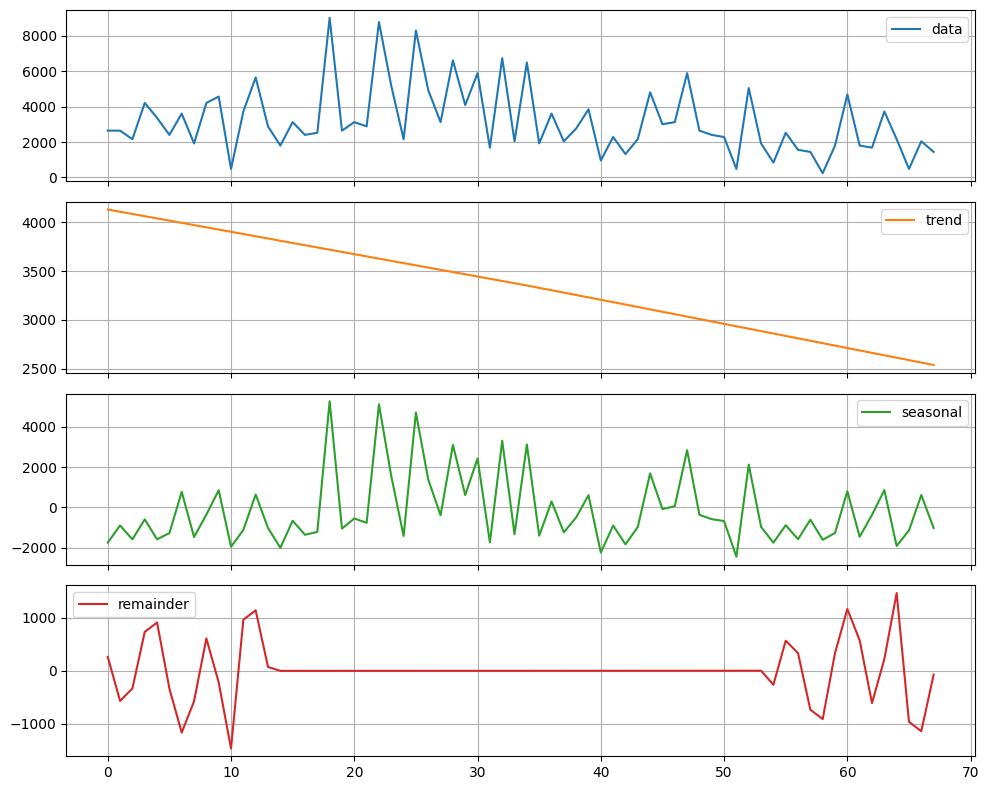

In [4]:
# decompose the time series
from statsforecast.models import MSTL
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

sf =  StatsForecast(models=[MSTL(season_length=[input_size] )], freq="M")
sf.fit(m3)

decomposition = sf.fitted_[0, 0].model_
print(decomposition.head())

# Plot the decomposed components: observed, trend, seasonal, and remainder.
decomposition.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

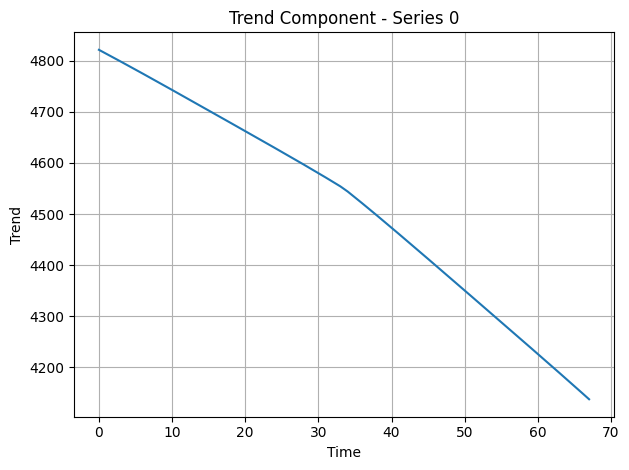

In [5]:
# Create datasets from decomposed components
trend = pd.DataFrame([sf.fitted_[i, 0].model_['trend'].values for i in range(len(sf.fitted_))])
seasonal = pd.DataFrame([sf.fitted_[i, 0].model_['seasonal'].values for i in range(len(sf.fitted_))])
remainder = pd.DataFrame([sf.fitted_[i, 0].model_['remainder'].values for i in range(len(sf.fitted_))])

# Plot the trend of the first series
plt.plot(trend.iloc[1])
plt.title("Trend Component - Series 0")
plt.xlabel("Time")
plt.ylabel("Trend")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def convert_to_nixtla_format(df, component_name="trend", time_index=None):
    long_df = df.copy()
    long_df["unique_id"] = [f"series_{i}" for i in range(len(df))]
    long_df = long_df.melt(id_vars=["unique_id"], var_name="time_idx", value_name="y")


    long_df["ds"] = long_df["time_idx"].astype(int)

    long_df = long_df[["unique_id", "ds", "y"]]

    #remove nan
    long_df = long_df.dropna()
    
    return long_df

trend_ds = convert_to_nixtla_format(trend, "trend")
seasonal_ds = convert_to_nixtla_format(seasonal, "seasonal")
remainder_ds = convert_to_nixtla_format(remainder, "remainder")


In [7]:
# create test and train datasets

Y_train_trend, Y_test_trend = train_test_split(trend_ds, horizon)
Y_train_seasonal, Y_test_seasonal = train_test_split(seasonal_ds, horizon)
Y_train_remainder, Y_test_remainder = train_test_split(remainder_ds, horizon)

Y_train_trend

,unique_id,ds,y
0,series_0,0,4129.029285
1,series_0,1,4106.355263
2,series_0,2,4083.662604
3,series_0,3,4060.952032
4,series_0,4,4038.225254
...,...,...,...
141853,series_999,121,3756.133376
141854,series_999,122,3769.082032
141855,series_999,123,3782.019603
141856,series_999,124,3794.949215


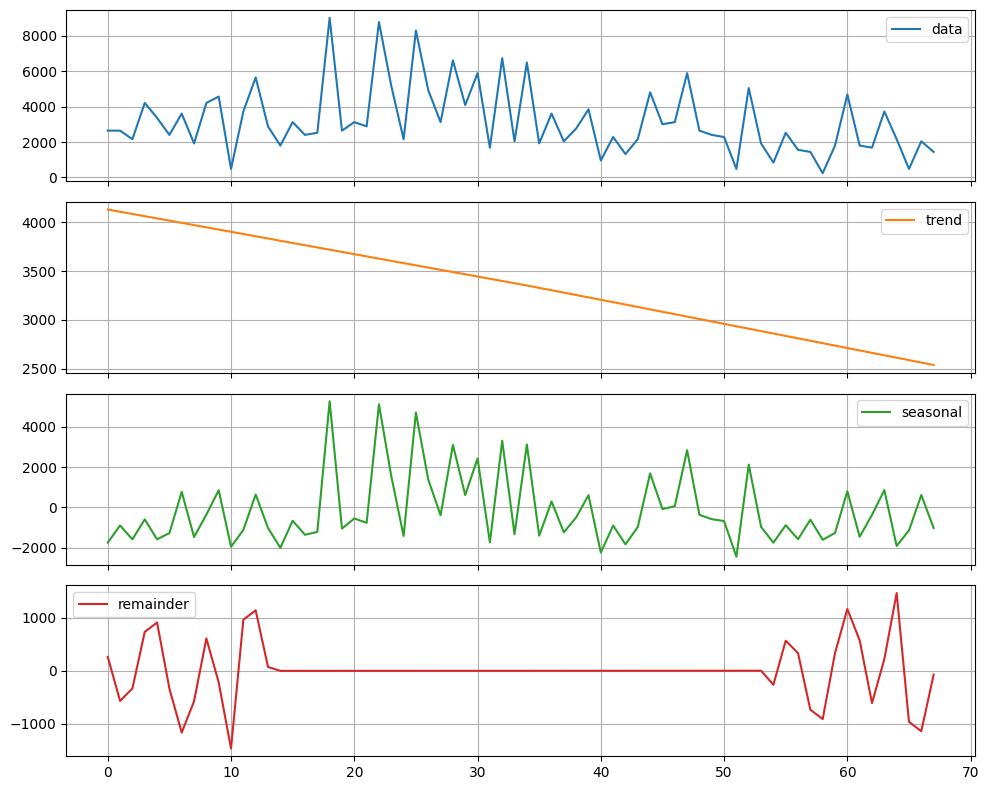

In [8]:
sf.fitted_[0, 0].model_.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

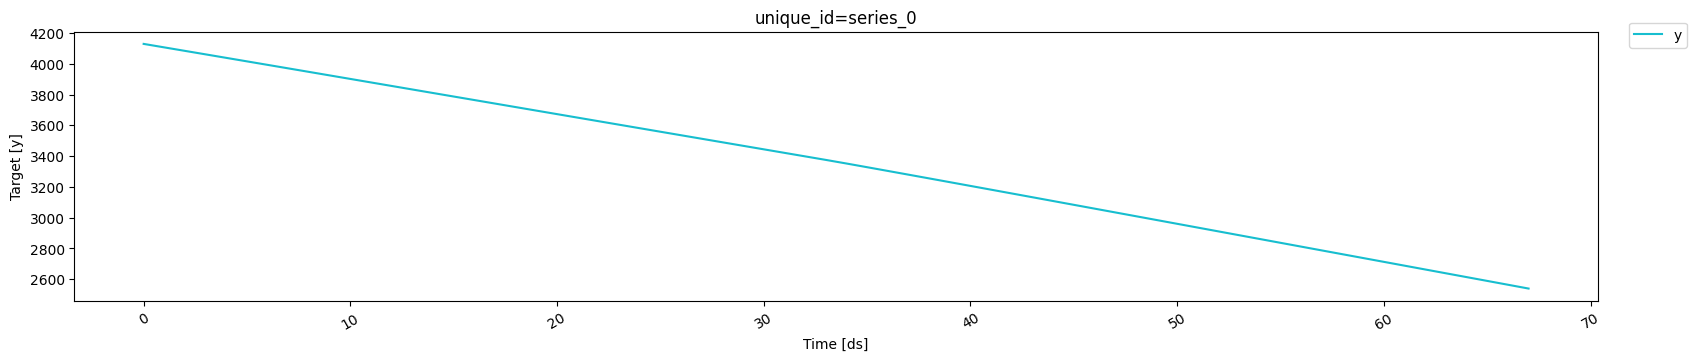

In [9]:
# plot series_0 from trend~
plot_series(Y_train_trend, Y_test_trend, ids=['series_0'])



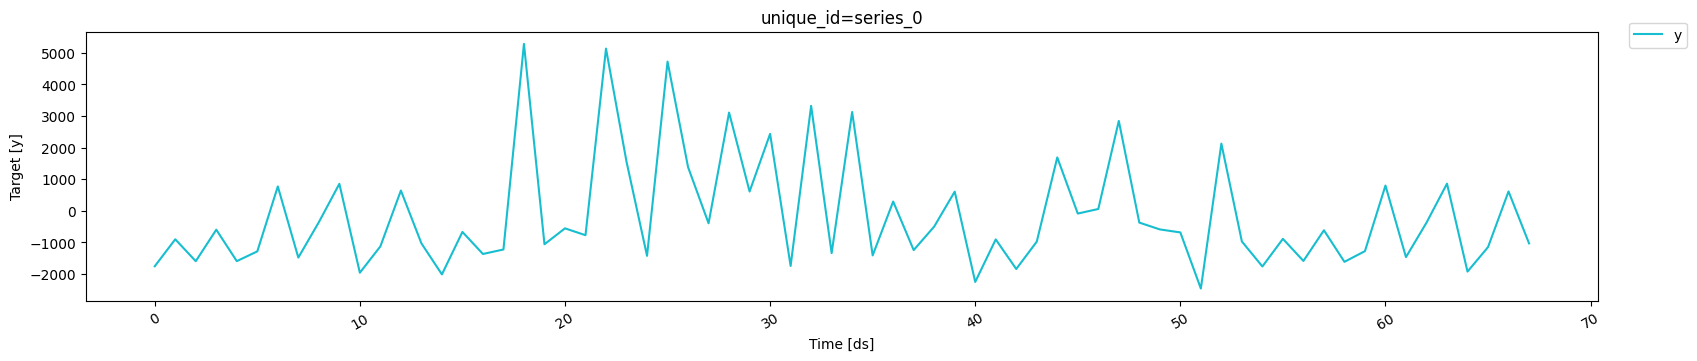

In [10]:
plot_series(Y_train_seasonal, Y_test_seasonal, ids=['series_0'])

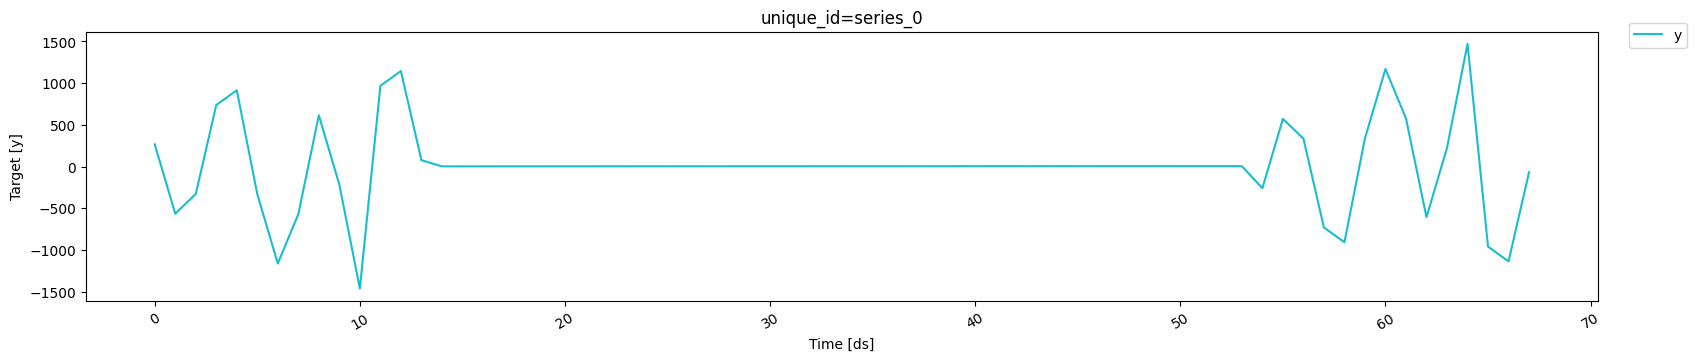

In [11]:
plot_series(Y_train_remainder, Y_test_remainder, ids=['series_0'])

In [12]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except KeyError as exc:
        raise KeyError(
            f"Forecast column '{forecast_col}' not found in predictions!") from exc
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

First the trend component ...

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.12it/s, v_num=167, train_loss_step=60.90, train_loss_epoch=71.40, valid_loss=45.70]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 14.77it/s, v_num=167, train_loss_step=60.90, train_loss_epoch=71.40, valid_loss=45.70]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 123.94it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[1191,  627,   86],
        [ 137, 1389,  462],
        [1102,  794,  119],
        [1295,  802,  174],
        [1306,  283,  457],
        [1256, 1379,  392],
        [ 756,  230,  415],
        [ 733,  208,  782],
        [1413,  281, 1095],
        [1168, 1374,  168]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.5860, 0.9729, 0.6992],
        [0.5309, 0.9402, 0.6933],
        [0.4675, 0.9298, 0.6920],
        [0.4651, 0.9287, 0.6798],
        [0.4641, 0.9280, 0.6726],
        [0.4424, 0.9251, 0.6703],
        [0.4304, 0.9219, 0.6702],
        [0.4255, 0.9149, 0.6676],
        [0.4236, 0.9042, 0.6669],
        [0.4122, 0.8988, 0.6667]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([6200.4683, 6204.8364, 6208.6919, 6212.0142, 6214.8008, 6217.0640,
        6218.8418, 6220.1924, 6221.1724, 6221.8369, 6222.2358, 622

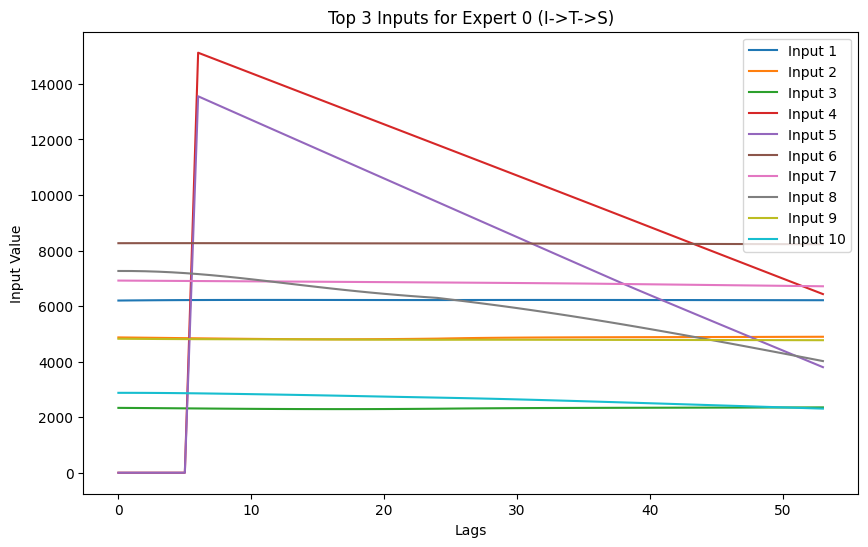

expert_top_inputs[:, 0]: tensor([5151.8135, 5144.8105, 5138.1108, 5131.7251, 5125.6602, 5119.9160,
        5114.4834, 5109.3408, 5104.4614, 5099.8140, 5095.3647, 5091.0801,
        5086.9272, 5082.8750, 5078.8965, 5074.9683, 5071.0708, 5067.1880,
        5063.3071, 5059.4185, 5055.5146, 5051.5879, 5047.6313, 5043.6401,
        5039.6089, 5035.5342, 5031.4150, 5027.2515, 5023.0483, 5018.8159,
        5014.5737, 5010.3564, 5006.2266, 5002.2964, 5009.5215, 5028.9014,
        5049.6357, 5071.4316, 5094.0752, 5117.4087, 5141.3110, 5165.6875,
        5190.4619, 5215.5723, 5240.9663, 5266.6016, 5292.4419, 5318.4570,
        5344.6226, 5370.9180, 5397.3271, 5423.8364, 5450.4360, 5477.1162],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([4140.2607, 4142.0259, 4143.0044, 4143.2158, 4142.6865, 4141.4512,
        4139.5581, 4137.0703, 4134.0586, 4130.5947, 4126.7539, 4122.6030,
        4118.1968, 4113.5732, 4108.7598, 4103.7725, 4098.6323, 4093.3706,
        4088.0354, 4082.6968, 4077.43

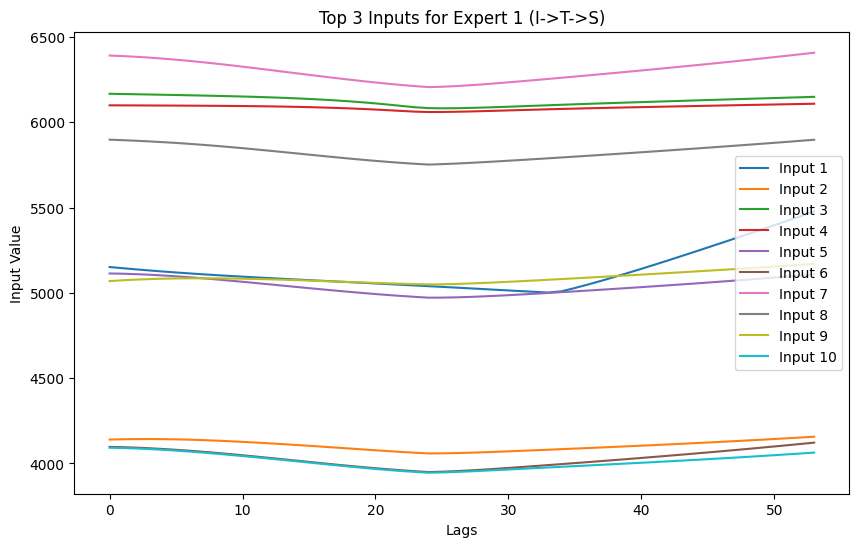

expert_top_inputs[:, 0]: tensor([4699.9141, 4706.0469, 4711.9844, 4717.7871, 4723.5347, 4729.3330,
        4735.3115, 4741.6108, 4748.3589, 4755.6475, 4763.5112, 4771.9199,
        4780.7773, 4789.9399, 4799.2422, 4808.5229, 4817.6470, 4826.5225,
        4835.1016, 4843.3682, 4851.3140, 4858.9097, 4866.0869, 4872.7314,
        4878.6904, 4878.0229, 4875.9922, 4872.7617, 4868.5728, 4863.6440,
        4858.1465, 4852.2051, 4845.9097, 4839.3267, 4832.5093, 4825.5005,
        4818.3389, 4811.0566, 4803.6821, 4796.2383, 4788.7422, 4781.2061,
        4773.6367, 4766.0396, 4758.4160, 4750.7666, 4743.0918, 4735.3911,
        4727.6641, 4719.9097, 4712.1255, 4704.3076, 4696.4502, 4688.5444],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([5972.8374, 5980.2827, 5987.8442, 5995.5273, 6003.3315, 6011.2510,
        6019.2739, 6027.3813, 6035.5532, 6043.7666, 6051.9956, 6060.2012,
        6068.3345, 6076.3325, 6084.1255, 6091.6372, 6098.7920, 6105.5142,
        6111.7314, 6117.3770, 6122.39

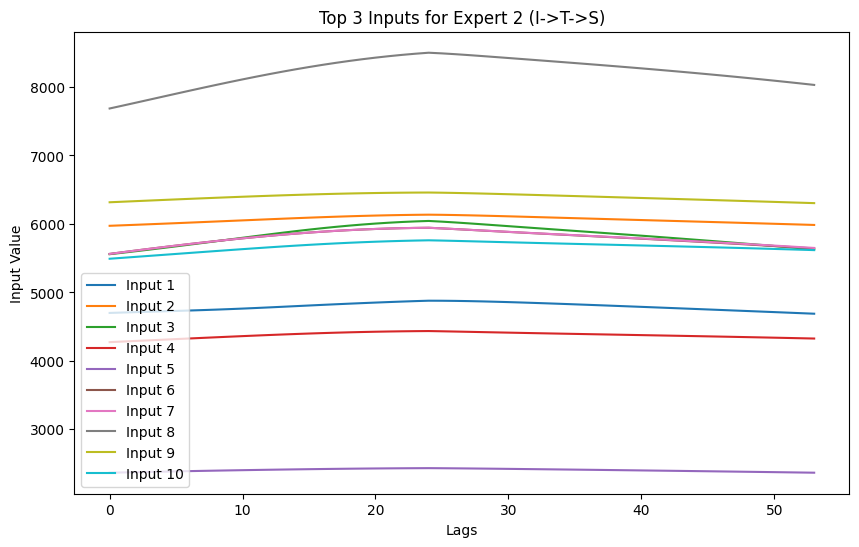

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 40.73it/s] 
sMAPE for trend: 0.013450725325108248


In [13]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_trend, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_trend)

smape_trend = calculate_smape(Y_test_trend, predictions, 'NBeatsStackMoe')
print(f'sMAPE for trend: {smape_trend}')

... now the seasonal component ...

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.31it/s, v_num=169, train_loss_step=172.0, train_loss_epoch=165.0, valid_loss=200.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:03, 11.31it/s, v_num=169, train_loss_step=172.0, train_loss_epoch=165.0, valid_loss=200.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 103.78it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[1308, 1108,  946],
        [ 963,  849,   75],
        [ 105, 1153,  928],
        [1413, 1042,  313],
        [1189,  838,  678],
        [  50,   35,   68],
        [  45,  108,  800],
        [1252,  852,  159],
        [  25, 1034,  740],
        [1339,   16, 1254]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.3550, 0.3481, 0.3943],
        [0.3537, 0.3461, 0.3922],
        [0.3514, 0.3455, 0.3911],
        [0.3504, 0.3451, 0.3910],
        [0.3469, 0.3439, 0.3900],
        [0.3462, 0.3418, 0.3897],
        [0.3429, 0.3401, 0.3896],
        [0.3411, 0.3400, 0.3895],
        [0.3407, 0.3395, 0.3894],
        [0.3400, 0.3393, 0.3891]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([-138.5481,  279.7289,  210.8537,  482.5703,   17.4909, -385.6597,
         208.9217, -219.0957,   13.6289,  159.2728, -335.9411, -46

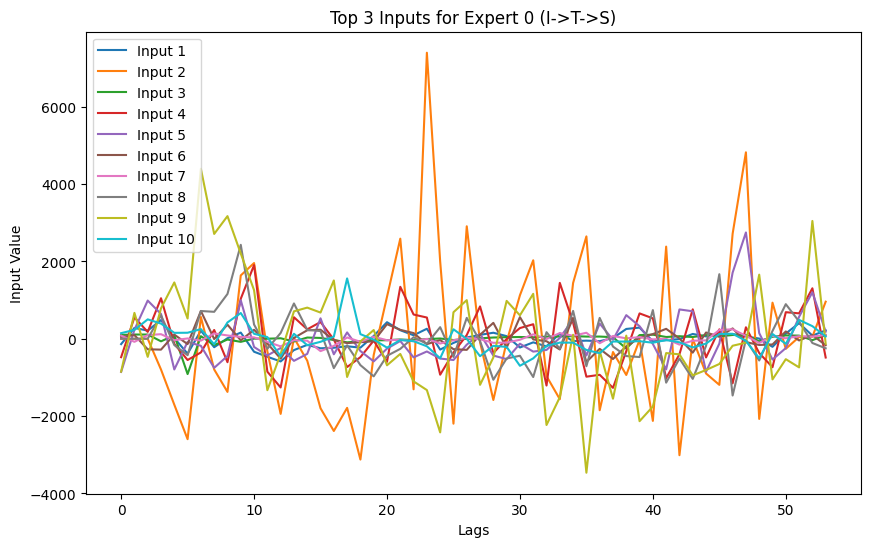

expert_top_inputs[:, 0]: tensor([ -186.9333, -1796.1241, -1124.5872,  -154.5538,  -770.7057,   779.5136,
         -437.8096,   883.4017,   572.9465,   992.4138,   258.8865,  -217.3132,
          113.3452,  -464.4342,   -45.7829,   460.4371,    69.8639,  -200.5906,
          493.5767,   956.3303,  1325.1898,   791.7156,   917.6046,   413.4796,
         -462.0728,  -357.1316,   729.3472,  -740.6286, -1375.9196,  -552.3940,
        -1366.6652,   266.3326,   331.1737,  1290.7443,  -352.3122,  -531.0107,
         -211.8591,  -737.5071,   278.0779,    -5.8173,  -628.6943,  -784.7455,
          628.2272,  1083.2771,   323.8248,  -345.9733,  1319.7073,  -880.1104,
           21.0679,  -664.2283,   603.4493,  -771.1219,  -595.4154,   846.4848],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([   0.0000,    0.0000,    0.0000,   96.1772, -253.2664,  -77.6103,
        -386.7323,    8.2837,    3.5826, -551.4375, -630.9946,   29.7312,
         278.6905, -512.3093, -449.7763, -189.8559, -225.

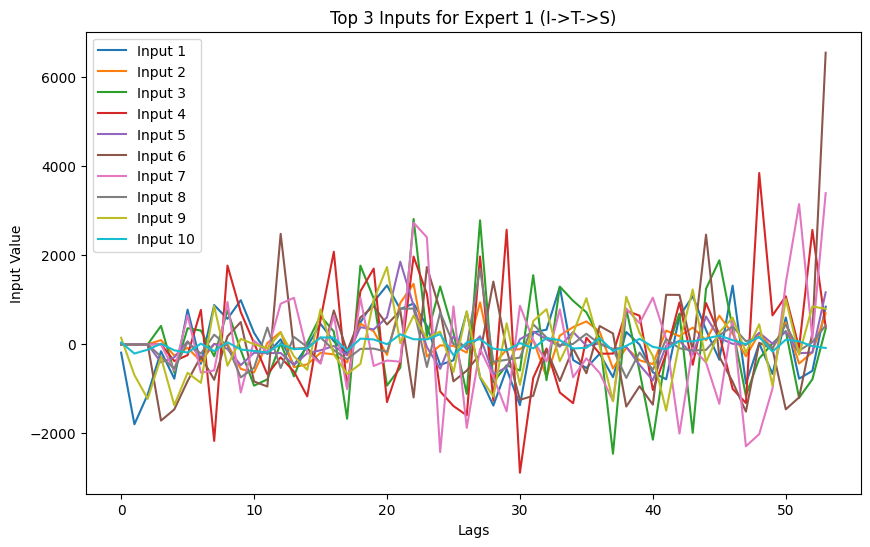

expert_top_inputs[:, 0]: tensor([    0.0000,     0.0000,     0.0000,    38.2886,  -613.2623,   283.6442,
         -342.5595,   474.8771, -1781.3970,  1090.5483,   767.3364,   713.7892,
         -294.6744,  1132.3097,  -327.1902,  -598.9581,  -322.7520,  -795.4415,
         -268.9765,   313.4889,  -364.0409,  1298.4347,  1520.9165,  -896.5942,
         -314.0959, -1591.5863,   -49.0629,   413.4776,   516.0393,   258.6270,
         1021.2466,  -496.0948,  2006.6115,  -230.6242,   832.2110,  -324.8674,
           18.1603,   541.3193,   526.5599,  -688.1151,  1337.2750,   362.7157,
          168.1960,  -146.2928,   259.2426,  -295.2036,   290.3644,    95.9434,
         -758.4695,   547.1237, -1087.2787,  -441.6778, -1236.0746, -1310.4696],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([ -57.2010,  -45.6346,  -15.1065,   52.8126,  100.3321,  -76.5758,
         -63.9588,  -52.1429, -102.5951,  -32.6709,   70.9130,   44.2803,
         122.9263,   50.0667,   -8.6432,  120.3594,  177.

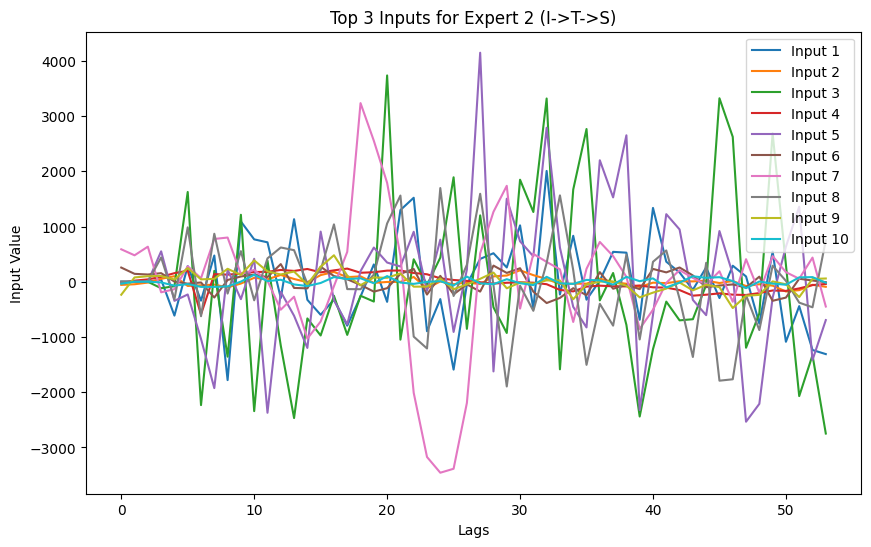

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 35.89it/s] 
sMAPE for seasonal: 0.22683849020533964


In [14]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_seasonal, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_seasonal)

smape_seasonal = calculate_smape(Y_test_seasonal, predictions, 'NBeatsStackMoe')
print(f'sMAPE for seasonal: {smape_seasonal}')

... and the remainder

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:01<00:04,  7.94it/s, v_num=171, train_loss_step=203.0, train_loss_epoch=228.0, valid_loss=188.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:01<00:04,  7.94it/s, v_num=171, train_loss_step=203.0, train_loss_epoch=228.0, valid_loss=188.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 67.83it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[ 387,  964, 1266],
        [ 170,  255,  455],
        [ 338, 1384,  907],
        [ 337,  506, 1317],
        [ 548,   11,  675],
        [ 781,  730,  651],
        [ 414,  950,  559],
        [1330,  378,  875],
        [ 783,  345,  549],
        [ 281,  263,  456]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.5350, 0.4360, 0.6162],
        [0.5276, 0.4312, 0.5965],
        [0.5224, 0.4149, 0.5913],
        [0.5217, 0.4108, 0.5894],
        [0.5197, 0.4099, 0.5876],
        [0.5176, 0.4099, 0.5869],
        [0.5173, 0.4082, 0.5859],
        [0.5129, 0.4078, 0.5851],
        [0.5088, 0.4059, 0.5850],
        [0.5078, 0.4057, 0.5838]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([ 78.1824,  84.0539,  90.6447,  70.8381,  68.9378,  66.4256,  71.8975,
         64.1916,  40.0014,  21.1494,  29.4586,  12.6874,  -8.6

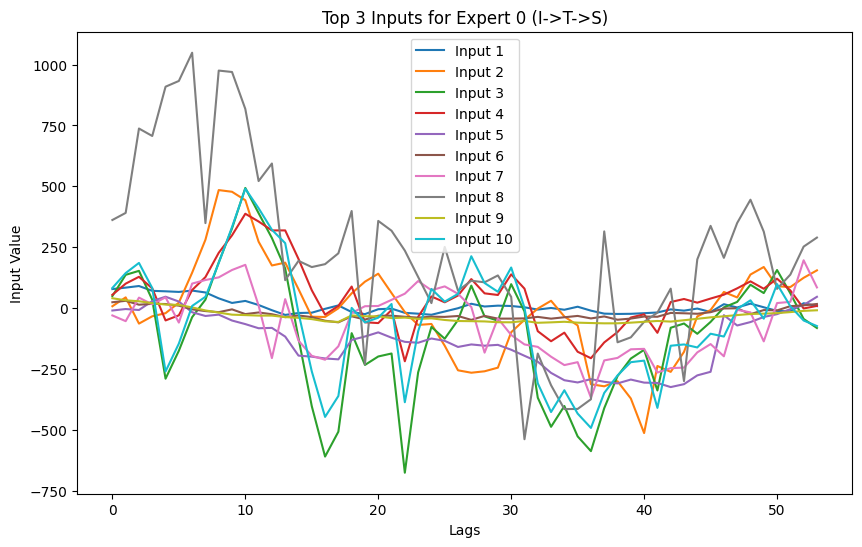

expert_top_inputs[:, 0]: tensor([    0.0000,     0.0000,     0.0000,  -192.4654,   841.7832, -1532.3788,
         2021.1998, -2279.4165,   -59.5193,   678.4747,  -806.4029, -1698.4912,
         -367.6748,  1704.1061, -1262.6820,   364.4866,  4807.2866, -2012.6113,
           10.9468,    10.9316,    10.9167,    10.9019,    10.8874,    10.8731,
           10.8590,    10.8451,    10.8315,    10.8180,    10.8049,    10.7920,
           10.7797,    10.7683,    10.7572,    10.7465,    10.7360,    10.7258,
           10.7158,    10.7059,    10.7052,    10.7046,    10.7040,    10.7034,
           10.7028,    10.7023,    10.7018,    10.7018,    10.7022,    10.7027,
           10.7035,    10.7044,    10.7054,    10.7066,    10.7080,    10.7095],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([-109.8335, -147.3870, -102.4404, -130.1009, -169.1154, -150.8212,
        -168.5804, -162.6223, -159.1288, -168.4745, -105.6976, -108.1259,
         -60.1728,  -81.3858,  -65.5683,  -77.9379,  -80.

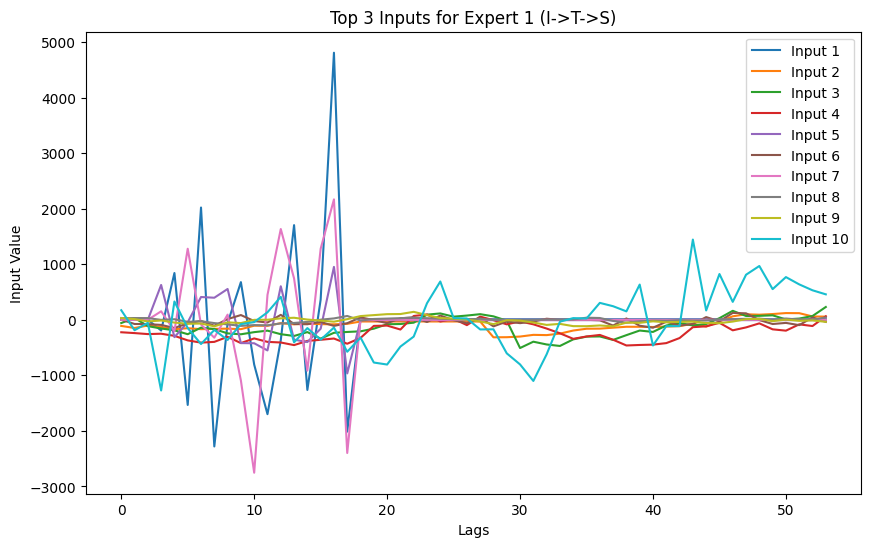

expert_top_inputs[:, 0]: tensor([-45.8064,   3.4244,  -5.4069,   5.4121,  17.7078, -23.0626,  12.0679,
         38.8013,  29.0503,  20.8572,  30.7720,  57.1595,  66.9738,  65.1938,
         56.7976,  35.1903,  79.7452,  48.3037,  40.1053,  28.7938,  62.0347,
         53.3917, 160.9476, -17.8768,  20.7874, 102.8546, 103.6277,  99.6413,
        105.6990,  47.7095,  19.1060,  37.7082,  31.8848,  68.3195,  65.5050,
         80.2476,  74.2941, 129.8144, 102.6281,  93.4119,  98.0227, 160.7825,
         71.1131,  72.8698,  56.6210,  16.8096,  32.1711,  84.6059, 115.5082,
         77.9622,  34.8055,  11.5635,  64.7762, -31.3106], device='cuda:0')
expert_top_inputs[:, 1]: tensor([-44.2943, -27.7017, -18.3959, -19.3200,  13.1393,  28.2298,  57.8603,
         75.6792,  80.9256, 114.6974, 142.7056, 142.1024, 153.1945, 191.6236,
        234.6774, 217.7851, 260.1498, 225.6516, 140.4780, 138.3644, 151.6467,
        119.8866, 134.0964, 141.0442,  94.8056, 117.0645, 121.3704, 153.2224,
        186.6089

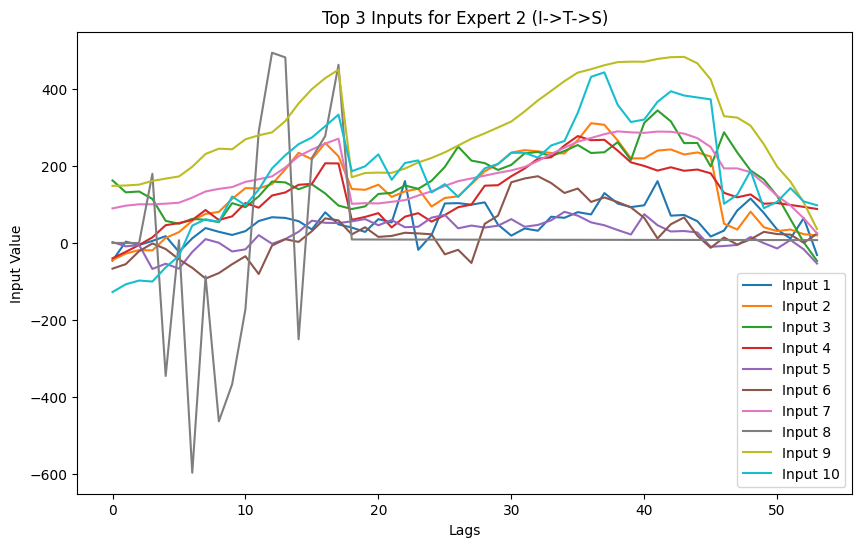

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 30.11it/s]
sMAPE for remainder: 1.10119426335456


In [15]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_remainder, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_remainder)

smape_remainder = calculate_smape(Y_test_remainder, predictions, 'NBeatsStackMoe')
print(f'sMAPE for remainder: {smape_remainder}')